# <a id='toc1_'></a>[Descripción del proyecto](#toc0_)

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

**Table of contents**<a id='toc0_'></a>    
- [Descripción del proyecto](#toc1_)    
  - [Inicialización](#toc1_1_)    
  - [Descripción de los datos](#toc1_2_)    
  - [Preparación](#toc1_3_)    
  - [Análisis](#toc1_4_)    
  - [Formación](#toc1_5_)    
    - [Modelo dummy (Ridge)](#toc1_5_1_)    
    - [Árbol aleatorio de decisiones (DecisionTreeRegressor)](#toc1_5_2_)    
    - [Bosques Aleatorios Sklearn (RandomForestRegressor)](#toc1_5_3_)    
    - [LightGBM](#toc1_5_4_)    
    - [XGBoost (XGBoostRegressor)](#toc1_5_5_)    
  - [Prueba](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Inicialización](#toc0_)

In [1]:
# Primero cargamos las librerias que vamos a usar
# Las librerías fundamentales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Funciones para el trabajo con los datos y modelos
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, kpss

# Y los modelos que vamos a usar
import lightgbm as gbm
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

## <a id='toc1_2_'></a>[Descripción de los datos](#toc0_)

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

In [2]:
# Cargamos nuestro dataset en una varaible
df = pd.read_csv('../../data/raw/taxi.csv', parse_dates=True, index_col=[0])

In [3]:
# Veamos el panorama general de la tabla
df.info()
display(df.describe())
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Para nuestro placer podemos ver como no hay valores nulos en nuestro dataset y _read_csv_ logró interpretar bien a la tabla `datetime`. Contamos con casi 26500 filas que van desde el 1 de Mayo al 31 de Agosto de 2018 separadas en rangos de 10 minutos. 
  
Podemos notar como la cantidad de ordenes posee un grado de variabilidad considerable con un CV de 65,47 (_100 * desv.est. / promedio_) lo que se nota claramente llegando a un máximo de ordenes de 119 en **10** minutos. Veamos en más detalle todo ésto!

## <a id='toc1_3_'></a>[Preparación](#toc0_)

Vamos a verificar con matemáticas si la cantidad de filas corresponden a las esperadas para ese lapso de tiempo con ese step.
  
Para eso tenemos que considerar que obtendríamos 6 filas por hora, por 24 horas al día por los 184 días que corresponden a dicho lapso de tiempo.

In [4]:
6*24*184

26496

In [5]:
# Realizamos el remuestro de los datos
resampled_df = df.resample('1H').sum()

In [6]:
# Veamos un poco el df ahora
resampled_df.info()
display(resampled_df.describe())
resampled_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## <a id='toc1_4_'></a>[Análisis](#toc0_)

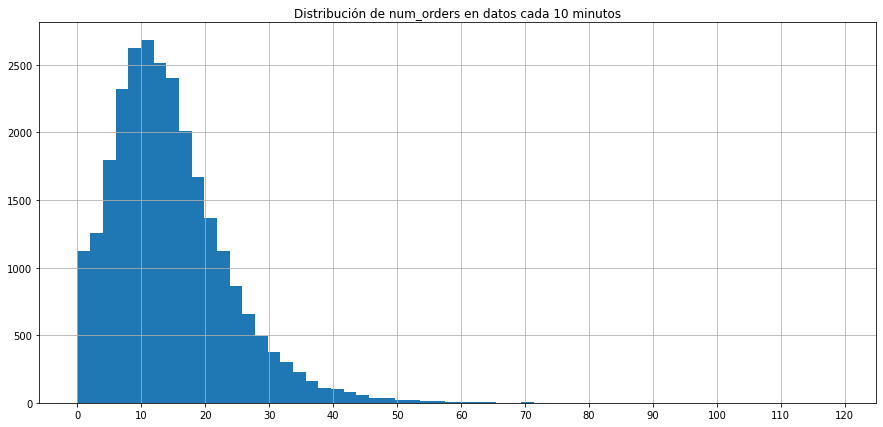

In [7]:
# Veamos la distribución de los datos cada 10 min
plt.figure(figsize=(15,7))
df['num_orders'].hist(bins=60)
plt.title('Distribución de num_orders en datos cada 10 minutos')
plt.xticks(range(0,130,10))
plt.show()

Podemos ver como la distribución indica que la cantidad de pedidos en 10 minutos más comunes rondan alrededor de los 10 pedidos con una distribución que quiere parecer normal.

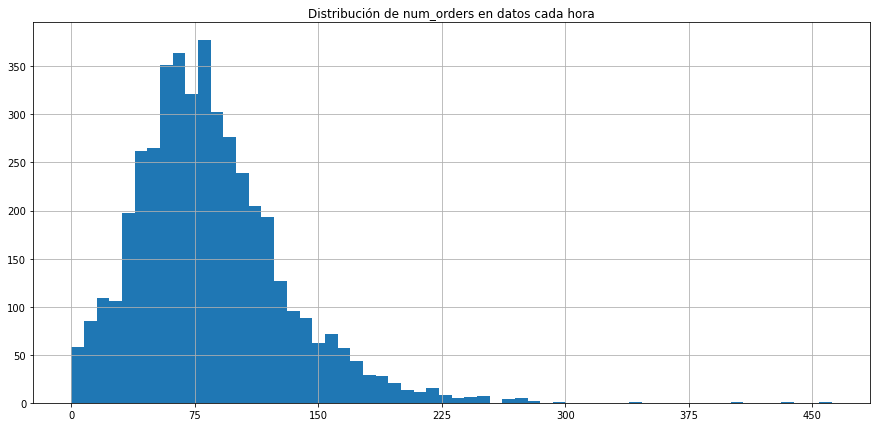

In [8]:
# Ahora la de los datos separados por hora
plt.figure(figsize=(15,7))
resampled_df['num_orders'].hist(bins=60)
plt.title('Distribución de num_orders en datos cada hora')
plt.xticks(range(0,475,75))
plt.show()

El hecho de que los histogramas hayan llegado tan lejos me hace pensar que posiblmenete no estemos hablando de una serie estacionaria, para verificar eso vamos a recurrir a dos pruebas estadísticas que nos ayudaran a obtener la respuesta.

In [9]:
'''
La prueba ADFuller trabaja sobre las siguientes hipótesis:

- Hipótesis Nula (H0): La serie no es estacionaria, la serie tiene una raíz unitaria.
- Hipótesis Alternativa (H1): La serie es estacionaria, o no tiene una raíz unitaria.
'''
def adf_test(timeseries):
    print ('Resultados de la prueba Dicky-Fuller Aumentada:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Usados','Numero de observaciones usadas'])
    for key,value in dftest[4].items():
        dfoutput['Valor Crítico (%s)'%key] = value
    with pd.option_context('display.float_format', lambda x: f'{x:,.6f}'):
        print(dfoutput)

In [10]:
'''
La prueba KPSS trabaja sobre las siguientes hipótesis:

- La hipótesis nula (H0) de la prueba es que los datos son estacionarios.
- La hipótesis alternativa (H1) para la prueba es que los datos no son estacionarios.
'''

def kpss_test(timeseries):
    print ('Resultados de la prueba KPSS:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Usados'])
    for key,value in kpsstest[3].items():
        kpss_output['Valor crítico (%s)'%key] = value
    with pd.option_context('display.float_format', lambda x: f'{x:,.6f}'):    
        print(kpss_output)

In [11]:
adf_test(df['num_orders'])

Resultados de la prueba Dicky-Fuller Aumentada:
Test Statistic                      -12.548885
p-value                               0.000000
#Lags Usados                         48.000000
Numero de observaciones usadas   26,447.000000
Valor Crítico (1%)                   -3.430597
Valor Crítico (5%)                   -2.861649
Valor Crítico (10%)                  -2.566828
dtype: float64


Al parecer el p-value de la prueba es menor que 0,05 y el Test Statistic de la prueba es menor que los valores críticos. Con esos datos no tenemos razones para no rechazar la hipótesis nula por lo que podemos llegar a la conclusión de que la serie temporal es estacionaria. Por si acaso vamos a probar con la prueba KPSS que plantea unas hipótesis opuestas a las que tiene la prueba ADF.

In [12]:
kpss_test(df['num_orders'])

Resultados de la prueba KPSS:
Test Statistic         21.761984
p-value                 0.010000
#Lags Usados           85.000000
Valor crítico (10%)     0.347000
Valor crítico (5%)      0.463000
Valor crítico (2.5%)    0.574000
Valor crítico (1%)      0.739000
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Como podemos ver nos encontramos en una situacion bastante peculiar. Nuestra prueba KPSS arrojó un p-value menor que 0,05 con un Test Statistic mayor que todos los valores críticos por lo que tenemos que rechazar la hipótesis nula a favor de la alternativa.
  
Pero si pensamos bien, eso indicaría que la serie no es estacionaria? Acaso la prueba ADF no dijo lo contrario? Cual prueba tiene razón?
  
Las pruebas estadísticas no son fórmulas mágicas que nos revelan la verdad de la vida. Uno realiza las dos pruebas precisamente para lograr obtener la mayor cantidad de información y sacar las conclusiones con mayor conocimiento en las manos.
  
En éste caso con ambas pruebas favoreciendo sus respectivas hipótesis alternativas podemos concluir que nuestra serie temporal es estacionaria diferencial. Por lo tanto como está no podemos decir que es estacionaria pero si realizamos el trabajo de diferenciar _n_ veces eventualmente llegaremos a obtener un conjunto de datos estacionarios. El trabajo pesado es obtener el valor _n_ más chico posible para no perder tantos datos. Hay que hacerlo ahora?
  
Ese labor puede ser muy beneficioso para modelar los datos pero conlleva un tiempo manual y computacional. Por ahora voy a trabajar con los datos como están (no estacionarios) y si veo que no podemos alcanzar el RECM máximo si voy a buscar ese _n_ para diferenciarlo y finalmente obtener los datos estacionarios.


Por su parte la forma normal se pierde con el remuestreo de datos y observamos como la cantidad común de ordenes por hora está cerca de 75.
Ahora veamos como fue cambiando a lo largo del tiempo la cantidad de visitas

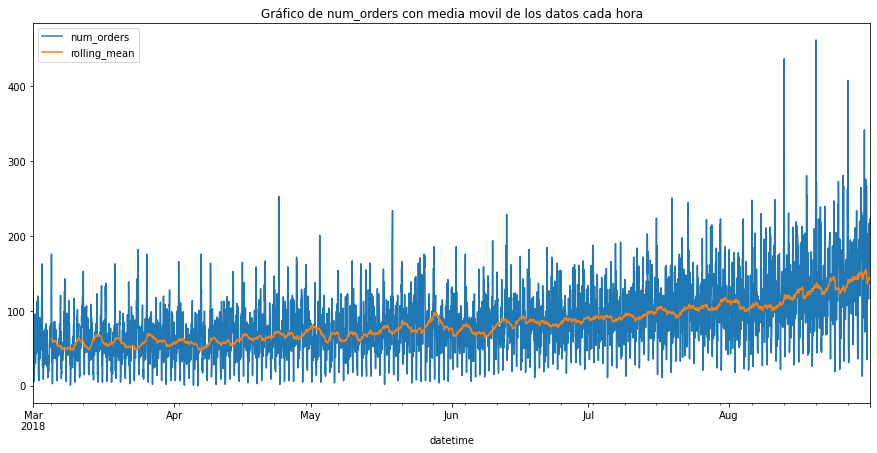

In [13]:
# Ahora veamos utilizando herramientas para el análisis de series temporales
resampled_df['rolling_mean'] = resampled_df.shift(50).rolling(50).mean()
resampled_df.plot(figsize=(15,7))
plt.title('Gráfico de num_orders con media movil de los datos cada hora')
plt.show()


Éste gráfico no es lindo por decir poco aunque podemos ver como la media móvil presenta una leve tendencia a subir con una subida más fuerte en los últimos meses. Veamos si se presenta alguna estacionalidad muy marcada.

In [14]:
# Realizamos la descomposición con el df original para que la función tenga acceso a toda la info
decomposed_hour = seasonal_decompose(df, period=6)

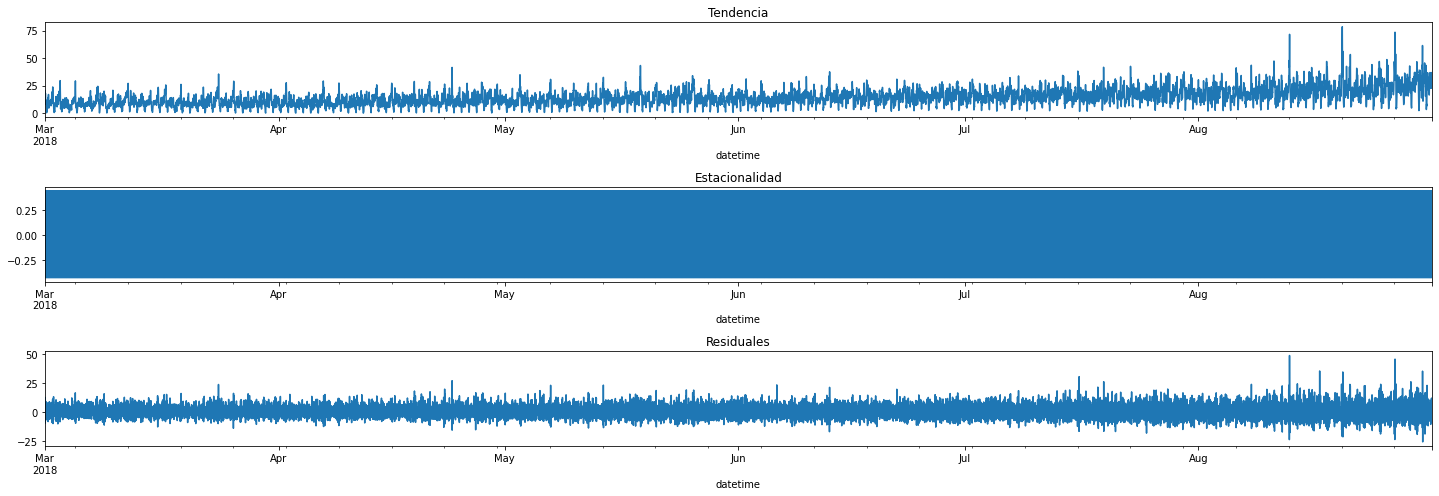

In [15]:
# Ahora graficamos la Tendencia, Estacionalidad y los Residuales
plt.figure(figsize=(20, 7))

plt.subplot(311)
decomposed_hour.trend.plot(ax=plt.gca())
plt.title('Tendencia')

plt.subplot(312)
decomposed_hour.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')

plt.subplot(313)
decomposed_hour.resid.plot(ax=plt.gca())
plt.title('Residuales')

plt.tight_layout()

La tendencia es muy similar a lo que veíamos con la media móvil, la estacionalidad... tendremos que verla de más cerca aunque no parece afectar mucho (al menos no bajo ese periodo) y los residuales tienen un impacto comparable al de la tendencia.
  
Como dije, veamos de cerca que nos dice la estacionalidad bajo en 2 periodos.

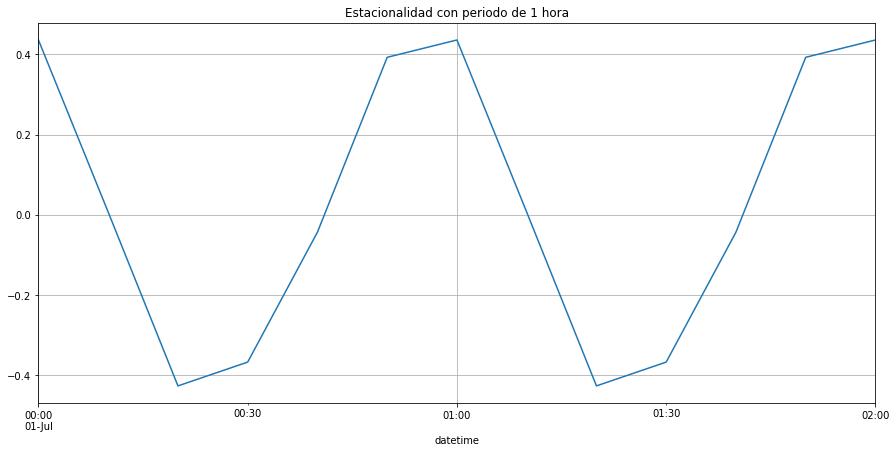

In [16]:
decomposed_hour.seasonal['2018-07-01 00:00:00':'2018-07-01 02:00:00'].plot(figsize=(15,7))
plt.title('Estacionalidad con periodo de 1 hora')
plt.grid(True)
plt.show()

Como dije, la estacionalidad no parece afectar mucho en el rango de una hora, ya que el rango completo de la gráfica es de 0,8! Si uno lo piensa bien, tiene sentido ya que pocas veces es importante en que momento de la hora uno pida un taxi mientras que por lo general es más importante es a que hora en concreto uno lo pide. Probemos otro periodo y veamos si nos da un componente estacional que demuestre un mayor impacto. Voy a probar separando el día en 4 partes.

In [17]:
decomposed_6_hour = seasonal_decompose(df, period=36)

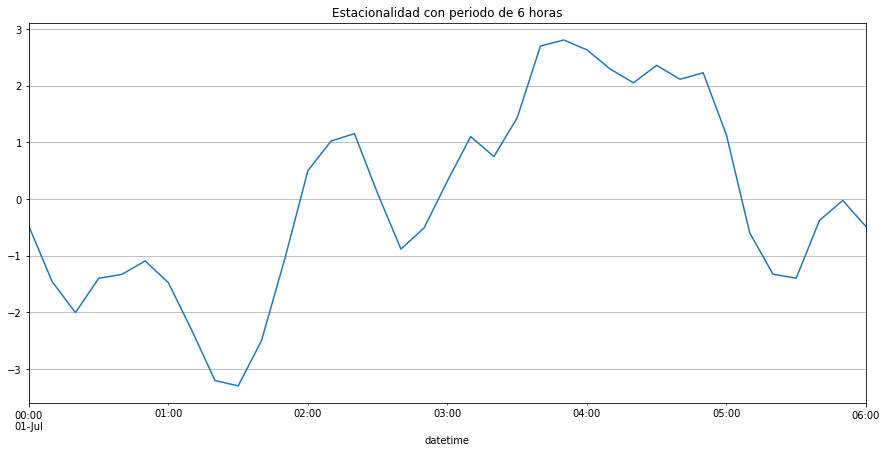

In [18]:
decomposed_6_hour.seasonal['2018-07-01 00:00:00':'2018-07-01 06:00:00'].plot(figsize=(15,7))
plt.title('Estacionalidad con periodo de 6 horas')
plt.grid(True)
plt.show()

In [19]:
# Ya que 6 horas no parece tener tanto impacto, veamos la estacionalidad en un día
decomposed_day = seasonal_decompose(df, period=144)

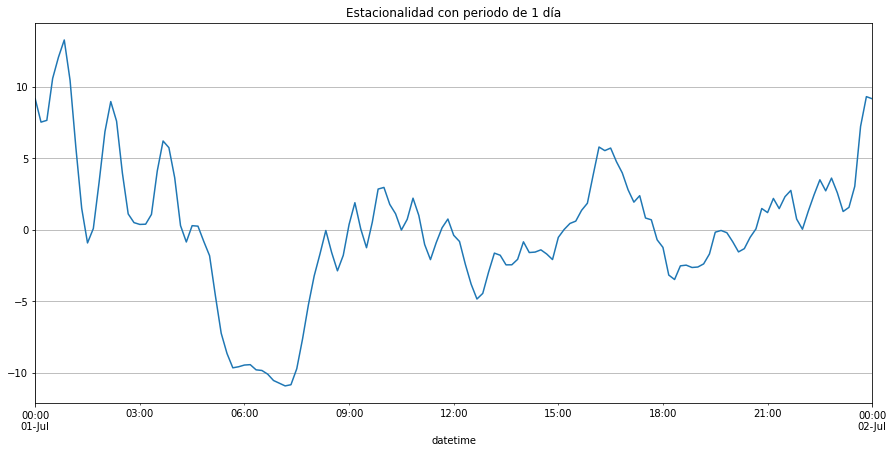

In [20]:
decomposed_day.seasonal['2018-07-01 00:00:00':'2018-07-02 00:00:00'].plot(figsize=(15,7))
plt.title('Estacionalidad con periodo de 1 día')
plt.grid(True)
plt.show()

Ahora si empezamos a ver números que posicionana a la estacionalidad como una variable importante (o minimamente una variable no despreciable).  Podemos ver como alrededor de las 00:00 de cada día hay un pico importante en los pedidos de taxis. Ésto se puede explicar por muchas formas como que la gente que llega (o va) de los vuelos en últimos horarios ya que suelen ser menos costosos, también puede deberse a que posiblemente a esa hora muchos locales comerciales cierran sus puertas y sus empleados deben retirarse a sus hogares.
  
De la misma forma que a las 00:00 vemos un pico, cerca de las 6:00 se ve un "valle" que para las 8:30 aproximadamente ya vuelve a valores neutros. Posteriormente se ve que la estacionalidad oscila alrededor del 0 hasta las 12:00 cuando los pedidos bajan. Posteriormente los pedidos vuelven a subir con un pico cerca de las 17:00 que en el lapso de una hora vuelve a bajar. El pico de las 17 se podría atribuir también al cambio de horario de los empleados de comercio ya que a esa hora se retirarían las personas que ingresaron a las 8:00.
  
Finalmente vemos como gradualmente el número de pedidos va subiendo hasta llegar al pico que vemos al comienzo del gráfico.

In [21]:
# Ahora veamos la semana
decomposed_week = seasonal_decompose(df, period=1008)

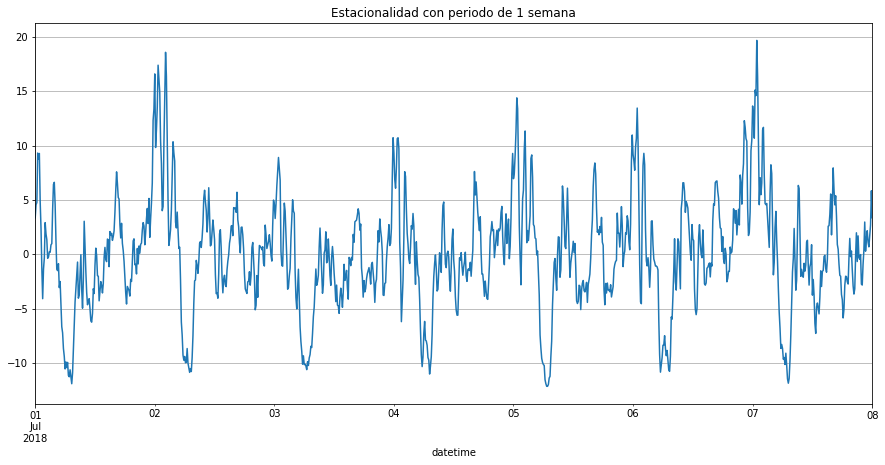

In [22]:
decomposed_week.seasonal['2018-07-01 00:00:00':'2018-07-08 00:00:00'].plot(figsize=(15,7))
plt.title('Estacionalidad con periodo de 1 semana')
plt.grid(True)
plt.show()

Antes que nada hay que dejar dicho que el 1 de Julio de 2018 fue Domingo. Si nos ponemos a ver muy finalmente parece ser que el patrón diario que nos encontramos antes efectivamente se repite día tras día en la gráfica semanal pero tambien podemos notar como hay algunos días que presentan un aumento de pedidos mayor que el resto (como el Domingo y el Viernes). Para asegurarme de que estamos tratando con una gráfica efectivamente similar y no estoy viendo cosas que no hay veamos solo un día de la gráfica.

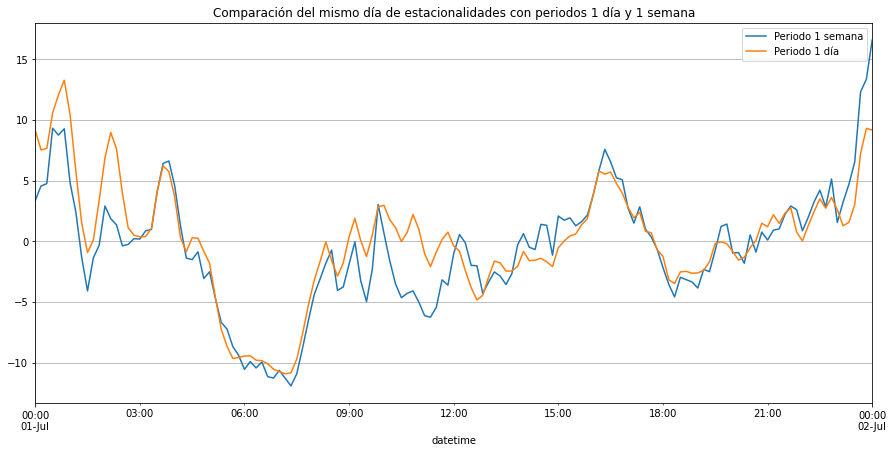

In [23]:
plt.figure(figsize=(15,7))
decomposed_week.seasonal['2018-07-01 00:00:00':'2018-07-02 00:00:00'].plot(label='Periodo 1 semana')
decomposed_day.seasonal['2018-07-01 00:00:00':'2018-07-02 00:00:00'].plot(label='Periodo 1 día')
plt.grid(True)
plt.title('Comparación del mismo día de estacionalidades con periodos 1 día y 1 semana')
plt.legend()
plt.show()

En retrospectiva tiene sentido y por más que no sean exactamente iguales seguramente si ponderamos todos los días de la semana para colapsarlos en un mismo día nos va a dar algo muy parecido (o igual) al gráfico que tenemos cuando el periodo es 1 día.
  
Ahora con la comparación gráfica hecha quiero hacer un experimento en el que voy a buscar cancelar el componente estacional diario de la gráfica para ver solamente el impacto del día mismo. En otras palabras, voy a restar las gráficas para eliminar las fluctuaciones a lo largo del día y poder comparar más fácilmente la diferencia entre un Martes y un Sábado.

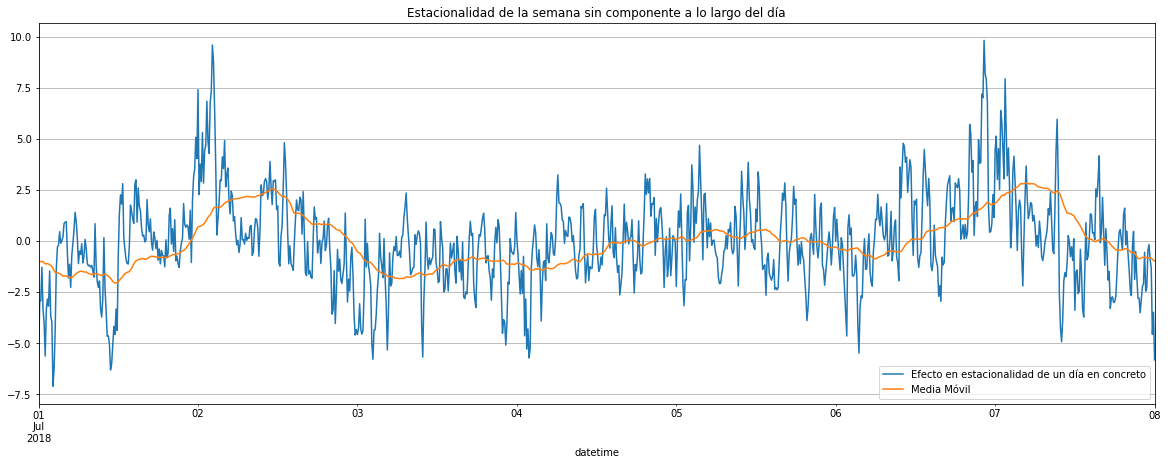

In [24]:
# Hacemos la resta y graficamos
(
decomposed_week.seasonal['2018-07-01 00:00:00':'2018-07-08 00:00:00'] -
decomposed_day.seasonal['2018-07-01 00:00:00':'2018-07-08 00:00:00']
).plot(figsize= (20,7), label='Efecto en estacionalidad de un día en concreto')

# Agregamos una media móvil con una ventana de medio día para mejor seguimiento
(
decomposed_week.seasonal['2018-06-30 00:00:00':'2018-07-08 00:00:00'] -
decomposed_day.seasonal['2018-06-30 00:00:00':'2018-07-08 00:00:00']
).rolling(72).mean().plot(label='Media Móvil')

# Agregamos límites de x, un título, leyenda y una grid
plt.title('Estacionalidad de la semana sin componente a lo largo del día')
plt.xlim(('2018-07-01 00:00:00','2018-07-08 00:00:00'))
plt.legend()
plt.grid(True)
plt.show()

Bueno... el gráfico no es el más bonito pero si podemos observar (un poco) un aproximado de como impacta cada día de la semana y vemos que el gráfico arroja unos resultados interesantes. La mayor actividad se registra el lunes y el sábado por la madrugada, de ahí en más vemos como el resto de los dias afectan levemente para abajo sin demostrar ningún efecto extremadamente notorio ni profundo que no se vea compensado por una subida similar.
  
Ahora veamos bien en detalle como se desglosan nuestros datos cuando utilizamos periodos de 6 horas, 1 día y 1 semana.

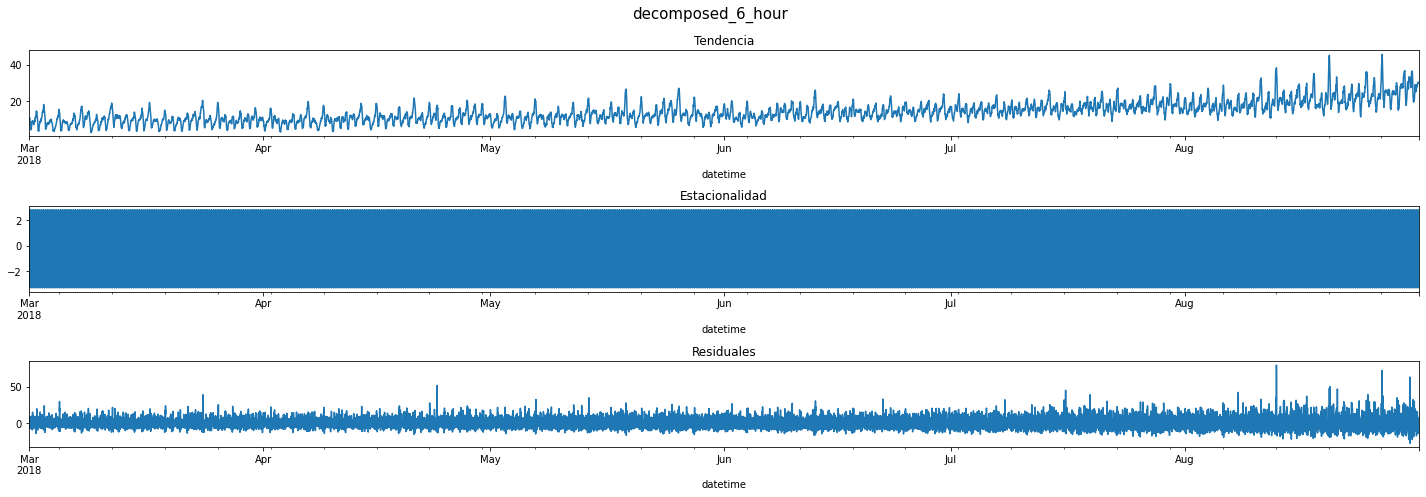

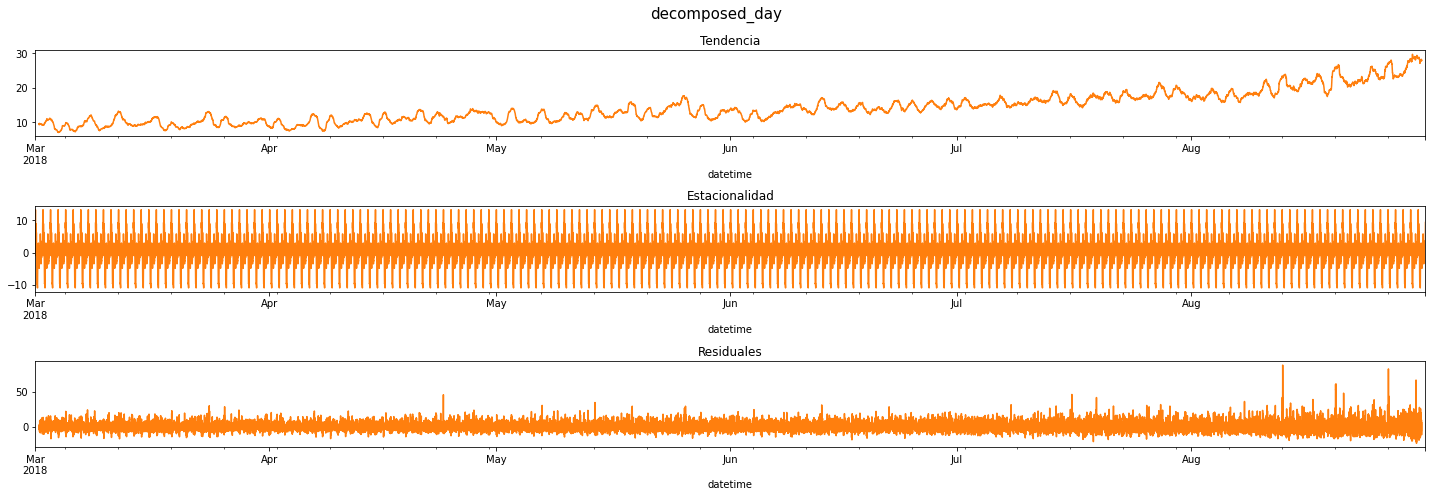

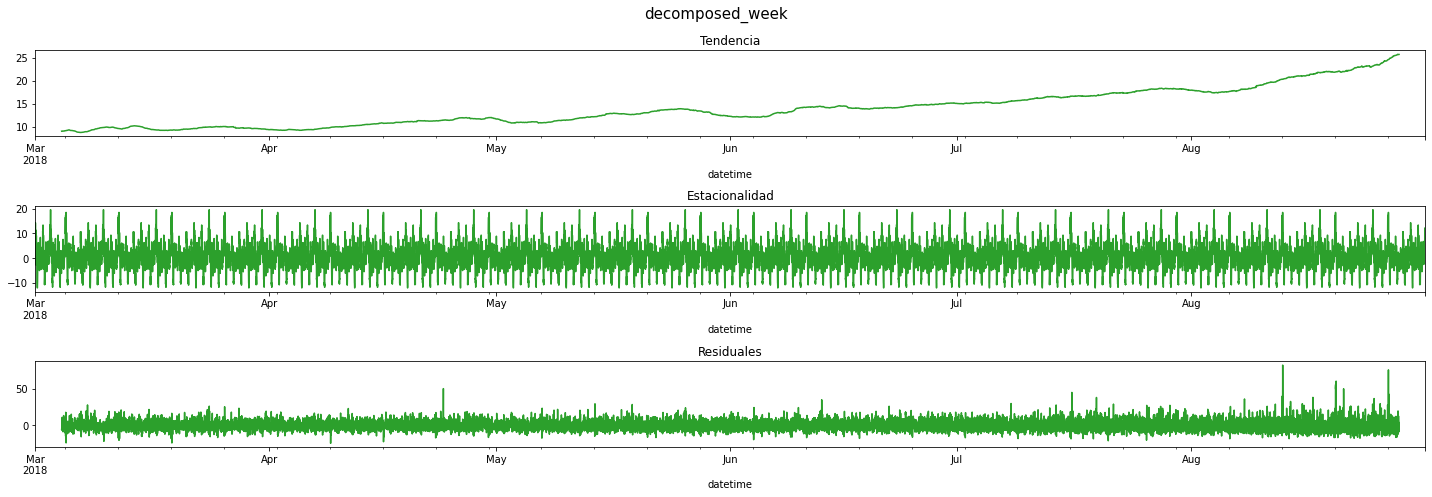

In [25]:
for decomposition, color in zip([decomposed_6_hour, decomposed_day, decomposed_week],['tab:blue','tab:orange','tab:green']):
    plt.figure(figsize=(20, 7))
    
    decom_name = [name for name, value in locals().items() if value is decomposition][0]

    plt.suptitle(f'{decom_name}', fontsize=15)
    plt.subplot(311)
    decomposition.trend.plot(ax=plt.gca(),color=color)
    plt.title('Tendencia')

    plt.subplot(312)
    decomposition.seasonal.plot(ax=plt.gca(),color=color)
    plt.title('Estacionalidad')

    plt.subplot(313)
    decomposition.resid.plot(ax=plt.gca(),color=color)
    plt.title('Residuales')
    
    plt.tight_layout()
    plt.show()

Podemos ver como conforme aumentamos el perido para identificar una estacionalidad la Tendencia se vuelve más suave y la estacionalidad pasa a tener un mayor impacto en los valores individuales, mientras a su vez los residuales parecen casi inmutados! Lamentablemente los residuales aún con todo ésto siguen teniendo un impacto mayor sobre nuestros datos pero con lo mencionado previamente tenemos un grado de confianza de que la estacionalidad pasa a ser más representativa a un ciclo real que conforma la cantidad de pedidos de taxis y la Tendencia logra mostrar de mejor manera el camino que están tomando la cantidad de pedidos de taxi.
  
Supongo que con todo ésto logramos recolectar bastante información bien interesante sobre el comportamiento de nuestros datos. Pudimos ver la tendencia general 

## <a id='toc1_5_'></a>[Formación](#toc0_)

Ahora vamos a pasar a la formación de nuestros modelos pero antes de ello tenemos que primero preparar los datos agregandole features.

In [26]:
# Primero eliminamos la función rolling_mean para poder calcularla posteriormente con valores diferentes
resampled_df.drop(columns='rolling_mean',inplace=True)

In [27]:
# Entonces creamos una función para ayudarnos con eso

def make_features(data, max_lag=5, rolling_mean_size=5):
    
    data_copy = data.copy()
    
    data_copy['year'] = data.index.year
    data_copy['month'] = data.index.month
    data_copy['day'] = data.index.day
    data_copy['hour'] = data.index.hour
    data_copy['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data_copy['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data_copy['rolling_mean'] = (
        data_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    )
    
    return data_copy

In [28]:
make_features(resampled_df, 10, 10)

,num_orders,year,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,19,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,173.3
2018-08-31 20:00:00,154,2018,8,31,20,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,166.6
2018-08-31 21:00:00,159,2018,8,31,21,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,162.9


In [29]:
# En vista de que funciona bien, lo guardemos en una función
df_with_features = make_features(resampled_df, 10, 10)

In [30]:
# Ahora creamos un df limpio
clean_df_with_features = df_with_features.dropna()
clean_df_with_features.head(7)

,num_orders,year,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,2018,3,1,10,3,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,52.5
2018-03-01 11:00:00,96,2018,3,1,11,3,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,46.5
2018-03-01 12:00:00,30,2018,3,1,12,3,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,47.6
2018-03-01 13:00:00,32,2018,3,1,13,3,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,43.5
2018-03-01 14:00:00,48,2018,3,1,14,3,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,40.1
2018-03-01 15:00:00,66,2018,3,1,15,3,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,40.6
2018-03-01 16:00:00,43,2018,3,1,16,3,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,46.6


In [31]:
# Separamos los datos en conjuntos de entrenamiento y prueba sin shuffle
train_set, test_set = train_test_split(clean_df_with_features, shuffle=False, test_size=0.1)

In [32]:
# Ahora definimos el target y las features
target = 'num_orders'
features = clean_df_with_features.drop(columns='num_orders').columns.values

### <a id='toc1_5_1_'></a>[Modelo dummy (Ridge)](#toc0_)

Primero vamos a hacer un modelo simple del cual no tenemos demasiadas esperanzas pero que nos sirve de buen punto de comparación para saber que tan bien o mal se comportan el resto de los modelos.

In [33]:
dummy_model = Ridge()
dummy_model.fit(train_set[features],train_set[target])

Ridge()

In [34]:
dummy_predict = dummy_model.predict(test_set[features])
RECM_dummy = mean_squared_error(test_set[target], dummy_predict, squared=False)
RECM_dummy

53.51560231535696

La predicción del modelo dummy no aprueba, lo que es obvio, pero no está nada lejos! Ciertamente nos da un punto de partida razonable. Sigamos adelante.

### <a id='toc1_5_2_'></a>[Árbol aleatorio de decisiones (DecisionTreeRegressor)](#toc0_)
Vamos a empezar de muy abajo con un modelo muy muy simple de un árbol de decisión enfocado en Regresión.

In [35]:
# Primero creamos el objeto search
tree_search = RandomizedSearchCV(
    DecisionTreeRegressor(),
    param_distributions = {
        'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
        'max_depth': np.arange(4,15),
        'min_samples_split': np.arange(200,2000),
        'min_samples_leaf': np.arange(200,800)
    },
    n_iter = 50,
    cv = 15,
    random_state = 44566
)

In [36]:
# Ahora hacemos el fit al search y vemos el mejor modelo que encontró
tree_search.fit(train_set[features], train_set[target])
tree_search.best_estimator_

DecisionTreeRegressor(max_depth=13, min_samples_leaf=284, min_samples_split=602)

In [37]:
# Creamos un modelo con los mejores h-parámetros
tree_model = tree_search.best_estimator_

In [38]:
# Lo entrenamos
tree_model.fit(train_set[features], train_set[target])

DecisionTreeRegressor(max_depth=13, min_samples_leaf=284, min_samples_split=602)

In [39]:
# Y veamos que tal se comporta
tree_predict = tree_model.predict(test_set[features])
RECM_tree = mean_squared_error(test_set[target], tree_predict, squared=False)
RECM_tree

60.37854603406865

Según los resultados y comparando con la prueba de cordura el modelo de árbol está completamente loco! No logró superar al modelo dummy pero no me voy a dar por vencido, probemos que sucede si en vez de un árbol usamos un bosque completo!

### <a id='toc1_5_3_'></a>[Bosques Aleatorios Sklearn (RandomForestRegressor)](#toc0_)
Ahora vamos a pasar a otro modelo que tampoco es de los más sofisticados, un bosque aleatorio de regresión común y corriente. Sin gradient boosting ni nada de esas técnicas... al menos no en el modelo ya que vamos a usar `RandomizedSearchCV` para la optimización de hiperparámetros con validación cruzada.

In [40]:
# Ahora vamos a repetir el RandomSearch con nuestro bosque
forest_search = RandomizedSearchCV(
    RandomForestRegressor(),
    param_distributions = {
        'n_estimators': np.arange(10,50),
        'max_depth': np.arange(3,15),
        'min_samples_split': np.arange(500,2000),
        'min_samples_leaf': np.arange(100,1200),
        'criterion': ['mse','mae'],
        'max_features':['auto','sqrt','log2'],
        'random_state': [44566]
    },
    n_iter = 10,
    scoring = 'neg_root_mean_squared_error',
    cv = 5,
    random_state = 44566,
    verbose=1)

In [41]:
# Entrenamos el search y vemos cual es el mejor modelo encontrado
forest_search.fit(train_set[features],train_set[target])
forest_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomForestRegressor(max_depth=7, max_features='sqrt', min_samples_leaf=417,
                      min_samples_split=755, n_estimators=49,
                      random_state=44566)

In [42]:
# Lo creamos en una variable y lo entrenamos
forest_model = forest_search.best_estimator_
forest_model.fit(train_set[features], train_set[target])

RandomForestRegressor(max_depth=7, max_features='sqrt', min_samples_leaf=417,
                      min_samples_split=755, n_estimators=49,
                      random_state=44566)

In [43]:
# Guardamos su prediccion, obtenemos su RECM y lo mostramos tambien
forest_predict = forest_model.predict(test_set[features])
RECM_forest = mean_squared_error(test_set[target], forest_predict, squared=False)
RECM_forest

70.33196350476612

Hay una frase que dice, no siempre más es mejor. Acá tenemos el ejemplo más claro de eso, tenemos mútiples árboles juntos que buscaron contestar una pregunta y juntos obtuvieron una respuesta peor que la que obteniamos con un árbol. Supongo que hay que enseñarle un poco más a los árboles como hacen algunas librerías.

### <a id='toc1_5_4_'></a>[LightGBM](#toc0_)
Ahora vamos a probar que tal le va a LightGBM con nuestros datos. Antes que nada hay que convertir los datos del df en int lo que no creo que tenga demasiados problemas.

In [44]:
gbm_train = train_set.astype(int)
gbm_test = test_set.astype(int)

In [45]:
# Identificamos las columnas categóricas
cat_columns = ['year', 'month', 'day', 'hour', 'dayofweek']

In [46]:
# Ahora replicaremos RandomSearch ya que los datos categóricos complican la situación al usar GBM y RandomSearchCV de sklearn
min = 99999999999999999999999 
iterations = 75

for i in range(iterations):
    # Creamos aleatoriamente los parámetros y cargamos con valores aleatorios dentro de los rangos deseados
    params = {}
    params['boosting_type'] = 'gbdt'
    params['num_leaves'] = np.random.randint(10,50)
    params['max_depth'] = np.random.randint(1,10)
    params['learning_rate'] = np.random.uniform(0.1,0.51)
    params['min_child_samples'] = np.random.randint(500,5000)
    params['colsample_bytree'] = np.random.uniform(0.1,1)
    params['early_stopping_round'] = 50
    
    # De ahi entrenamos el modelo y obtenemos sus predicciones
    gbm_model = gbm.LGBMRegressor(**params)
    gbm_model.fit(gbm_train[features], gbm_train[target], 
            feature_name='auto', categorical_feature= cat_columns,
            eval_set=[(gbm_test[features],gbm_test[target])], eval_metric='rmse')
    
    target_test_pred = gbm_model.predict(gbm_test[features])
    
    # Finalmente observamos el recm
    recm = mean_squared_error(target_test_pred, gbm_test[target], squared=False)
    train_recm = mean_squared_error(gbm_model.predict(gbm_train[features]), gbm_train[target], squared=False)
    
    # Y guardamos los datos si vimos un modelo mejor que el que teníamos
    if recm < min:
        min = recm
        pp = params
        tr_recm = train_recm
        
print("*" * 70)
print('RECM mínimo obtenido es:', min)
print('RECM de entrenamiento mínimo obtenido es:', tr_recm)
print('Con los parámetros:', pp)
print("*" * 70)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[1]	valid_0's rmse: 84.046	valid_0's l2: 7063.74
[2]	valid_0's rmse: 83.0272	valid_0's l2: 6893.52
[3]	valid_0's rmse: 82.3396	valid_0's l2: 6779.81
[4]	valid_0's rmse: 79.8834	valid_0's l2: 6381.36
[5]	valid_0's rmse: 79.2449	valid_0's l2: 6279.76
[6]	valid_0's rmse: 77.1806	valid_0's l2: 5956.85
[7]	valid_0's rmse: 75.7862	valid_0's l2: 5743.54
[8]	valid_0's rmse: 74.7116	valid_0's l2: 5581.82
[9]	valid_0's rmse: 74.2049	valid_0's l2: 5506.36
[10]	valid_0's rmse: 73.1353	valid_0's l2: 5348.77
[11]	valid_0's rmse: 72.4327	valid_0's l2: 5246.5
[12]	valid_0's rmse: 71.8019	valid_0's l2: 5155.52
[13]	valid_0's rmse: 71.0609	valid_0's l2: 5049.65
[14]	valid_0's rmse: 70.8611	valid_0's l2: 5021.3
[15]	valid_0's rmse: 70.3774	valid_0's l2: 4952.98
[16]	valid_0's rmse: 70.055	valid_0's l2: 4907.71
[17]	valid_0's rmse: 69.9474	valid_0's l2: 4892.63
[18]	val

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[1]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[2]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[3]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[4]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[5]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[6]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[7]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[8]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[9]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[10]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[11]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[12]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[13]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[14]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[15]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[16]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[17]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[18]

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.'

[1]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[2]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[3]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[4]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[5]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[6]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[7]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[8]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[9]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[10]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[11]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[12]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[13]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[14]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[15]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[16]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[17]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[18]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[19]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[20]	valid_0's rmse: 61.0279	valid_0's l

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[38]	valid_0's rmse: 63.0687	valid_0's l2: 3977.67
[39]	valid_0's rmse: 62.956	valid_0's l2: 3963.46
[40]	valid_0's rmse: 62.5513	valid_0's l2: 3912.67
[41]	valid_0's rmse: 62.1846	valid_0's l2: 3866.92
[42]	valid_0's rmse: 62.1629	valid_0's l2: 3864.23
[43]	valid_0's rmse: 62.0851	valid_0's l2: 3854.56
[44]	valid_0's rmse: 62.0047	valid_0's l2: 3844.58
[45]	valid_0's rmse: 61.9834	valid_0's l2: 3841.94
[46]	valid_0's rmse: 61.7097	valid_0's l2: 3808.09
[47]	valid_0's rmse: 61.6687	valid_0's l2: 3803.03
[48]	valid_0's rmse: 61.4625	valid_0's l2: 3777.63
[49]	valid_0's rmse: 61.3896	valid_0's l2: 3768.68
[50]	valid_0's rmse: 61.0646	valid_0's l2: 3728.88
[51]	valid_0's rmse: 60.9852	valid_0's l2: 3719.19
[52]	valid_0's rmse: 60.9158	valid_0's l2: 3710.74
[53]	valid_0's rmse: 60.8424	valid_0's l2: 3701.8
[54]	valid_0's rmse: 60.805	valid_0's l2: 3697.25
[55]	valid_0's rmse: 60.6496	valid_0's l2: 3678.37
[56]	valid_0's rmse: 60.3617	valid_0's l2: 3643.54
[57]	valid_0's rmse: 60.3279	valid

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')



[17]	valid_0's rmse: 56.1135	valid_0's l2: 3148.73
[18]	valid_0's rmse: 55.5776	valid_0's l2: 3088.86
[19]	valid_0's rmse: 55.4523	valid_0's l2: 3074.95
[20]	valid_0's rmse: 54.8489	valid_0's l2: 3008.4
[21]	valid_0's rmse: 54.6859	valid_0's l2: 2990.54
[22]	valid_0's rmse: 54.6792	valid_0's l2: 2989.81
[23]	valid_0's rmse: 54.3051	valid_0's l2: 2949.05
[24]	valid_0's rmse: 53.9526	valid_0's l2: 2910.88
[25]	valid_0's rmse: 53.855	valid_0's l2: 2900.36
[26]	valid_0's rmse: 53.59	valid_0's l2: 2871.89
[27]	valid_0's rmse: 53.4269	valid_0's l2: 2854.43
[28]	valid_0's rmse: 53.2657	valid_0's l2: 2837.24
[29]	valid_0's rmse: 53.1119	valid_0's l2: 2820.87
[30]	valid_0's rmse: 53.1915	valid_0's l2: 2829.33
[31]	valid_0's rmse: 53.0003	valid_0's l2: 2809.03
[32]	valid_0's rmse: 52.8374	valid_0's l2: 2791.79
[33]	valid_0's rmse: 52.4923	valid_0's l2: 2755.44
[34]	valid_0's rmse: 52.752	valid_0's l2: 2782.78
[35]	valid_0's rmse: 52.4487	valid_0's l2: 2750.86
[36]	valid_0's rmse: 52.2515	valid_

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[1]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[2]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[3]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[4]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[5]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[6]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[7]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[8]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[9]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[10]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[11]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[12]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[13]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[14]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[15]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[16]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[17]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[18]

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[1]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[2]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[3]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[4]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[5]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[6]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[7]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[8]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[9]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[10]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[11]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[12]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[13]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[14]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[15]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[16]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[17]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[18]

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')



[24]	valid_0's rmse: 64.4824	valid_0's l2: 4157.99
[25]	valid_0's rmse: 64.3952	valid_0's l2: 4146.75
[26]	valid_0's rmse: 63.4695	valid_0's l2: 4028.38
[27]	valid_0's rmse: 63.3388	valid_0's l2: 4011.8
[28]	valid_0's rmse: 63.7698	valid_0's l2: 4066.58
[29]	valid_0's rmse: 63.6796	valid_0's l2: 4055.1
[30]	valid_0's rmse: 63.4885	valid_0's l2: 4030.79
[31]	valid_0's rmse: 63.3396	valid_0's l2: 4011.9
[32]	valid_0's rmse: 63.6561	valid_0's l2: 4052.1
[33]	valid_0's rmse: 63.8587	valid_0's l2: 4077.94
[34]	valid_0's rmse: 63.3129	valid_0's l2: 4008.53
[35]	valid_0's rmse: 63.1271	valid_0's l2: 3985.03
[36]	valid_0's rmse: 63.0374	valid_0's l2: 3973.72
[37]	valid_0's rmse: 63.2571	valid_0's l2: 4001.47
[38]	valid_0's rmse: 62.9364	valid_0's l2: 3960.99
[39]	valid_0's rmse: 62.5705	valid_0's l2: 3915.07
[40]	valid_0's rmse: 62.5332	valid_0's l2: 3910.4
[41]	valid_0's rmse: 62.3116	valid_0's l2: 3882.73
[42]	valid_0's rmse: 62.0822	valid_0's l2: 3854.2
[43]	valid_0's rmse: 61.8965	valid_0

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[7]	valid_0's rmse: 73.0373	valid_0's l2: 5334.45
[8]	valid_0's rmse: 71.5491	valid_0's l2: 5119.27
[9]	valid_0's rmse: 71.2014	valid_0's l2: 5069.64
[10]	valid_0's rmse: 69.7089	valid_0's l2: 4859.33
[11]	valid_0's rmse: 69.3033	valid_0's l2: 4802.95
[12]	valid_0's rmse: 67.9388	valid_0's l2: 4615.68
[13]	valid_0's rmse: 67.5971	valid_0's l2: 4569.37
[14]	valid_0's rmse: 67.2346	valid_0's l2: 4520.49
[15]	valid_0's rmse: 66.9523	valid_0's l2: 4482.61
[16]	valid_0's rmse: 65.9548	valid_0's l2: 4350.04
[17]	valid_0's rmse: 65.6853	valid_0's l2: 4314.55
[18]	valid_0's rmse: 64.9826	valid_0's l2: 4222.73
[19]	valid_0's rmse: 64.8257	valid_0's l2: 4202.37
[20]	valid_0's rmse: 64.6828	valid_0's l2: 4183.87
[21]	valid_0's rmse: 63.836	valid_0's l2: 4075.04
[22]	valid_0's rmse: 63.6967	valid_0's l2: 4057.27
[23]	valid_0's rmse: 63.5467	valid_0's l2: 4038.18
[24]	valid_0's rmse: 63.4505	valid_0's l2: 4025.97
[25]	valid_0's rmse: 62.7672	valid_0's l2: 3939.72
[26]	valid_0's rmse: 62.6279	valid_

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3


[5]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[6]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[7]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[8]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[9]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[10]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[11]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[12]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[13]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[14]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[15]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[16]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[17]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[18]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[19]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[20]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[21]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[22]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[23]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[24]	valid_0's rmse: 61.0279	valid_

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.'


[2]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[3]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[4]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[5]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[6]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[7]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[8]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[9]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[10]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[11]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[12]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[13]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[14]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[15]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[16]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[17]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[18]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[19]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[20]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[21]	valid_0's rmse: 61.0279	valid_0's

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's rmse: 81.4984	valid_0's l2: 6641.98
[2]	valid_0's rmse: 80.3802	valid_0's l2: 6460.98
[3]	valid_0's rmse: 79.9047	valid_0's l2: 6384.76
[4]	valid_0's rmse: 75.8176	valid_0's l2: 5748.31
[5]	valid_0's rmse: 74.1898	valid_0's l2: 5504.13
[6]	valid_0's rmse: 71.9856	valid_0's l2: 5181.93
[7]	valid_0's rmse: 70.1223	valid_0's l2: 4917.14
[8]	valid_0's rmse: 68.2968	valid_0's l2: 4664.45
[9]	valid_0's rmse: 67.7473	valid_0's l2: 4589.7
[10]	valid_0's rmse: 66.4321	valid_0's l2: 4413.23
[11]	valid_0's rmse: 65.786	valid_0's l2: 4327.79
[12]	valid_0's rmse: 64.9905	valid_0's l2: 4223.76
[13]	valid_0's rmse: 64.6934	valid_0's l2: 4185.24
[14]	valid_0's rmse: 64.1861	valid_0's l2: 4119.86
[15]	valid_0's rmse: 63.9701	valid_0's l2: 4092.17
[16]	valid_0's rmse: 63.503	valid_0's l2: 4032.63
[17]	valid_0's rmse: 63.2365	valid_0's l2: 3998.86
[18]	valid_0's rmse: 62.0637	valid_0's l2: 3851.9
[19]	valid_0's rmse: 61.9122	valid_0's l2: 3833.12
[20]	valid_0's rmse: 61.5018	valid_0's l2: 3

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[1]	valid_0's rmse: 80.2005	valid_0's l2: 6432.13
[2]	valid_0's rmse: 76.3993	valid_0's l2: 5836.86
[3]	valid_0's rmse: 74.3289	valid_0's l2: 5524.78
[4]	valid_0's rmse: 72.9381	valid_0's l2: 5319.97
[5]	valid_0's rmse: 72.0265	valid_0's l2: 5187.81
[6]	valid_0's rmse: 69.4845	valid_0's l2: 4828.1
[7]	valid_0's rmse: 68.9713	valid_0's l2: 4757.04
[8]	valid_0's rmse: 68.3197	valid_0's l2: 4667.58
[9]	valid_0's rmse: 66.3426	valid_0's l2: 4401.34
[10]	valid_0's rmse: 65.979	valid_0's l2: 4353.23
[11]	valid_0's rmse: 65.576	valid_0's l2: 4300.22
[12]	valid_0's rmse: 64.0661	valid_0's l2: 4104.46
[13]	valid_0's rmse: 63.9062	valid_0's l2: 4084
[14]	valid_0's rmse: 63.6706	valid_0's l2: 4053.94
[15]	valid_0's rmse: 62.7139	valid_0's l2: 3933.03
[16]	valid_0's rmse: 62.542	valid_0's l2: 3911.51
[17]	valid_0's rmse: 62.0509	valid_0's l2: 3850.31
[18]	valid_

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[1]	valid_0's rmse: 83.6353	valid_0's l2: 6994.86
[2]	valid_0's rmse: 82.1766	valid_0's l2: 6753
[3]	valid_0's rmse: 81.2299	valid_0's l2: 6598.29
[4]	valid_0's rmse: 77.2033	valid_0's l2: 5960.36
[5]	valid_0's rmse: 76.5104	valid_0's l2: 5853.84
[6]	valid_0's rmse: 74.186	valid_0's l2: 5503.56
[7]	valid_0's rmse: 72.7838	valid_0's l2: 5297.49
[8]	valid_0's rmse: 71.1509	valid_0's l2: 5062.45
[9]	valid_0's rmse: 70.6562	valid_0's l2: 4992.29
[10]	valid_0's rmse: 70.1119	valid_0's l2: 4915.68
[11]	valid_0's rmse: 69.2656	valid_0's l2: 4797.72
[12]	valid_0's rmse: 69.1039	valid_0's l2: 4775.35
[13]	valid_0's rmse: 68.4055	valid_0's l2: 4679.31
[14]	valid_0's rmse: 68.3031	valid_0's l2: 4665.31
[15]	valid_0's rmse: 67.908	valid_0's l2: 4611.49
[16]	valid_0's rmse: 67.6646	valid_0's l2: 4578.49
[17]	valid_0's rmse: 67.4656	valid_0's l2: 4551.61
[18]	vali

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's rmse: 82.8714	valid_0's l2: 6867.67
[2]	valid_0's rmse: 80.3105	valid_0's l2: 6449.77
[3]	valid_0's rmse: 77.8172	valid_0's l2: 6055.52
[4]	valid_0's rmse: 75.865	valid_0's l2: 5755.51
[5]	valid_0's rmse: 75.2554	valid_0's l2: 5663.38
[6]	valid_0's rmse: 73.5621	valid_0's l2: 5411.38
[7]	valid_0's rmse: 72.3604	valid_0's l2: 5236.03
[8]	valid_0's rmse: 71.4737	valid_0's l2: 5108.49
[9]	valid_0's rmse: 70.3277	valid_0's l2: 4945.99
[10]	valid_0's rmse: 69.9366	valid_0's l2: 4891.12
[11]	valid_0's rmse: 68.8768	valid_0's l2: 4744.02
[12]	valid_0's rmse: 68.2216	valid_0's l2: 4654.18
[13]	valid_0's rmse: 67.5945	valid_0's l2: 4569.02
[14]	valid_0's rmse: 66.9315	valid_0's l2: 4479.83
[15]	valid_0's rmse: 66.4009	valid_0's l2: 4409.08
[16]	valid_0's rmse: 65.6799	valid_0's l2: 4313.85
[17]	valid_0's rmse: 65.2666	valid_0's l2: 4259.73
[18]	valid_0's rmse: 64.5475	valid_0's l2: 4166.38
[19]	valid_0's rmse: 64.4365	valid_0's l2: 4152.07
[20]	valid_0's rmse: 63.8174	valid_0's l2

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[1]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[2]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[3]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[4]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[5]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[6]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[7]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[8]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[9]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[10]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[11]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[12]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[13]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[14]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[15]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[16]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[17]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[18]

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.'

[1]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[2]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[3]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[4]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[5]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[6]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[7]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[8]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[9]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[10]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[11]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[12]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[13]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[14]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[15]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[16]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[17]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[18]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[19]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[20]	valid_0's rmse: 61.0279	valid_0's l

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3

[30]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[31]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[32]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[33]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[34]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[35]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[36]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[37]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[38]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[39]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[40]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[41]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[42]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[43]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[44]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[45]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[46]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[47]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[48]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[49]	valid_0's rmse: 61.0279	va

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.'

[32]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[33]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[34]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[35]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[36]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[37]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[38]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[39]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[40]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[41]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[42]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[43]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[44]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[45]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[46]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[47]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[48]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[49]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[50]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[51]	valid_0's rmse: 61.0279	va

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.'

[29]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[30]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[31]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[32]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[33]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[34]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[35]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[36]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[37]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[38]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[39]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[40]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[41]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[42]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[43]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[44]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[45]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[46]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[47]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[48]	valid_0's rmse: 61.0279	va

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/con

[32]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[33]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[34]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[35]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[36]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[37]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[38]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[39]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[40]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[41]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[42]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[43]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[44]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[45]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[46]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[47]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[48]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[49]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[50]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[51]	valid_0's rmse: 61.0279	va

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.'

[1]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[2]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[3]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[4]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[5]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[6]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[7]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[8]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[9]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[10]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[11]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[12]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[13]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[14]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[15]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[16]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[17]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[18]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[19]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[20]	valid_0's rmse: 61.0279	valid_0's l

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3

[1]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[2]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[3]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[4]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[5]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[6]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[7]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[8]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[9]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[10]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[11]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[12]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[13]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[14]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[15]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[16]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[17]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[18]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[19]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[20]	valid_0's rmse: 61.0279	valid_0's l

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[1]	valid_0's rmse: 82.2416	valid_0's l2: 6763.68
[2]	valid_0's rmse: 79.172	valid_0's l2: 6268.21
[3]	valid_0's rmse: 75.0787	valid_0's l2: 5636.81
[4]	valid_0's rmse: 72.2098	valid_0's l2: 5214.25
[5]	valid_0's rmse: 70.8676	valid_0's l2: 5022.22
[6]	valid_0's rmse: 69.8228	valid_0's l2: 4875.23
[7]	valid_0's rmse: 68.9149	valid_0's l2: 4749.27
[8]	valid_0's rmse: 66.9214	valid_0's l2: 4478.48
[9]	valid_0's rmse: 65.4889	valid_0's l2: 4288.8
[10]	valid_0's rmse: 63.8691	valid_0's l2: 4079.26
[11]	valid_0's rmse: 64.139	valid_0's l2: 4113.81
[12]	valid_0's rmse: 62.6068	valid_0's l2: 3919.61
[13]	valid_0's rmse: 62.308	valid_0's l2: 3882.29
[14]	valid_0's rmse: 62.2044	valid_0's l2: 3869.39
[15]	valid_0's rmse: 61.6342	valid_0's l2: 3798.78
[16]	valid_0's rmse: 61.8687	valid_0's l2: 3827.73
[17]	valid_0's rmse: 61.0674	valid_0's l2: 3729.23
[18]	val

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3

[9]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[10]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[11]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[12]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[13]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[14]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[15]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[16]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[17]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[18]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[19]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[20]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[21]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[22]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[23]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[24]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[25]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[26]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[27]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[28]	valid_0's rmse: 61.0279	val

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.'

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[1]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[2]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[3]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[4]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[5]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[6]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[7]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[8]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[9]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[10]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[11]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[12]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[13]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[14]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[15]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[16]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[17]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[18]

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3

[1]	valid_0's rmse: 81.3183	valid_0's l2: 6612.66
[2]	valid_0's rmse: 78.3251	valid_0's l2: 6134.83
[3]	valid_0's rmse: 76.6223	valid_0's l2: 5870.97
[4]	valid_0's rmse: 75.5332	valid_0's l2: 5705.27
[5]	valid_0's rmse: 74.6633	valid_0's l2: 5574.61
[6]	valid_0's rmse: 72.6787	valid_0's l2: 5282.19
[7]	valid_0's rmse: 72.1677	valid_0's l2: 5208.18
[8]	valid_0's rmse: 71.8978	valid_0's l2: 5169.3
[9]	valid_0's rmse: 70.0112	valid_0's l2: 4901.57
[10]	valid_0's rmse: 68.4049	valid_0's l2: 4679.23
[11]	valid_0's rmse: 67.8602	valid_0's l2: 4605.01
[12]	valid_0's rmse: 67.6327	valid_0's l2: 4574.19
[13]	valid_0's rmse: 67.2241	valid_0's l2: 4519.08
[14]	valid_0's rmse: 66.0583	valid_0's l2: 4363.7
[15]	valid_0's rmse: 65.0607	valid_0's l2: 4232.89
[16]	valid_0's rmse: 64.3811	valid_0's l2: 4144.93
[17]	valid_0's rmse: 64.3305	valid_0's l2: 4138.42
[18]	valid_0's rmse: 63.7781	valid_0's l2: 4067.65
[19]	valid_0's rmse: 63.4966	valid_0's l2: 4031.82
[20]	valid_0's rmse: 62.8528	valid_0's l2:

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's rmse: 79.0732	valid_0's l2: 6252.57
[2]	valid_0's rmse: 76.8766	valid_0's l2: 5910.01
[3]	valid_0's rmse: 73.9053	valid_0's l2: 5461.99
[4]	valid_0's rmse: 72.1388	valid_0's l2: 5204
[5]	valid_0's rmse: 71.111	valid_0's l2: 5056.78
[6]	valid_0's rmse: 68.034	valid_0's l2: 4628.63
[7]	valid_0's rmse: 67.3283	valid_0's l2: 4533.1
[8]	valid_0's rmse: 66.8312	valid_0's l2: 4466.41
[9]	valid_0's rmse: 63.8769	valid_0's l2: 4080.26
[10]	valid_0's rmse: 63.8591	valid_0's l2: 4077.99
[11]	valid_0's rmse: 62.6378	valid_0's l2: 3923.49
[12]	valid_0's rmse: 62.4559	valid_0's l2: 3900.74
[13]	valid_0's rmse: 61.3064	valid_0's l2: 3758.48
[14]	valid_0's rmse: 61.1865	valid_0's l2: 3743.79
[15]	valid_0's rmse: 60.6179	valid_0's l2: 3674.53
[16]	valid_0's rmse: 59.6707	valid_0's l2: 3560.59
[17]	valid_0's rmse: 59.5295	valid_0's l2: 3543.76
[18]	valid_0's rmse: 59.4077	valid_0's l2: 3529.27
[19]	valid_0's rmse: 59.2584	valid_0's l2: 3511.56
[20]	valid_0's rmse: 58.9538	valid_0's l2: 347

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3

[1]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[2]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[3]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[4]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[5]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[6]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[7]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[8]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[9]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[10]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[11]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[12]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[13]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[14]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[15]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[16]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[17]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[18]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[19]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[20]	valid_0's rmse: 61.0279	valid_0's l

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.'

[39]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[40]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[41]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[42]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[43]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[44]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[45]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[46]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[47]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[48]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[49]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[50]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[51]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[1]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[2]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[3]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[4]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3

[40]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[41]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[42]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[43]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[44]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[45]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[46]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[47]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[48]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[49]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[50]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[51]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[1]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[2]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[3]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[4]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[5]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[6]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[7]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[8]	valid_0's rmse: 61.0279	valid_0's 

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3

[1]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[2]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[3]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[4]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[5]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[6]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[7]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[8]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[9]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[10]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[11]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[12]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[13]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[14]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[15]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[16]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[17]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[18]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[19]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[20]	valid_0's rmse: 61.0279	valid_0's l

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[19]	valid_0's rmse: 64.6066	valid_0's l2: 4174.02
[20]	valid_0's rmse: 64.4178	valid_0's l2: 4149.66
[21]	valid_0's rmse: 64.2124	valid_0's l2: 4123.23
[22]	valid_0's rmse: 63.9829	valid_0's l2: 4093.81
[23]	valid_0's rmse: 63.877	valid_0's l2: 4080.28
[24]	valid_0's rmse: 63.4135	valid_0's l2: 4021.27
[25]	valid_0's rmse: 63.2468	valid_0's l2: 4000.16
[26]	valid_0's rmse: 62.9412	valid_0's l2: 3961.59
[27]	valid_0's rmse: 62.8426	valid_0's l2: 3949.19
[28]	valid_0's rmse: 62.6373	valid_0's l2: 3923.43
[29]	valid_0's rmse: 62.3499	valid_0's l2: 3887.51
[30]	valid_0's rmse: 62.2995	valid_0's l2: 3881.23
[31]	valid_0's rmse: 62.0286	valid_0's l2: 3847.55
[32]	valid_0's rmse: 61.7525	valid_0's l2: 3813.38
[33]	valid_0's rmse: 61.5901	valid_0's l2: 3793.34
[34]	valid_0's rmse: 61.5483	valid_0's l2: 3788.19
[35]	valid_0's rmse: 61.4234	valid_0's l2: 3772.84
[36]	valid_0's rmse: 61.1808	valid_0's l2: 3743.1
[37]	valid_0's rmse: 61.115	valid_0's l2: 3735.04
[38]	valid_0's rmse: 61.0268	valid

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[2]	valid_0's rmse: 79.6073	valid_0's l2: 6337.32
[3]	valid_0's rmse: 78.7697	valid_0's l2: 6204.67
[4]	valid_0's rmse: 77.0681	valid_0's l2: 5939.5
[5]	valid_0's rmse: 76.4697	valid_0's l2: 5847.62
[6]	valid_0's rmse: 74.3817	valid_0's l2: 5532.63
[7]	valid_0's rmse: 73.1048	valid_0's l2: 5344.31
[8]	valid_0's rmse: 72.698	valid_0's l2: 5285
[9]	valid_0's rmse: 72.1064	valid_0's l2: 5199.33
[10]	valid_0's rmse: 71.7712	valid_0's l2: 5151.11
[11]	valid_0's rmse: 69.577	valid_0's l2: 4840.95
[12]	valid_0's rmse: 69.7837	valid_0's l2: 4869.77
[13]	valid_0's rmse: 69.4675	valid_0's l2: 4825.73
[14]	valid_0's rmse: 69.6681	valid_0's l2: 4853.65
[15]	valid_0's rmse: 67.7161	valid_0's l2: 4585.47
[16]	valid_0's rmse: 67.5172	valid_0's l2: 4558.57
[17]	valid_0's rmse: 67.6962	valid_0's l2: 4582.78
[18]	valid_0's rmse: 67.5602	valid_0's l2: 4564.38
[19]	valid_0's rmse: 67.4919	valid_0's l2: 4555.16
[20]	valid_0's rmse: 67.7313	valid_0's l2: 4587.53
[21]	valid_0's rmse: 67.8769	valid_0's l2: 46

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3

[1]	valid_0's rmse: 82.0441	valid_0's l2: 6731.24
[2]	valid_0's rmse: 81.3202	valid_0's l2: 6612.98
[3]	valid_0's rmse: 80.6816	valid_0's l2: 6509.51
[4]	valid_0's rmse: 79.5102	valid_0's l2: 6321.87
[5]	valid_0's rmse: 78.9869	valid_0's l2: 6238.94
[6]	valid_0's rmse: 77.3904	valid_0's l2: 5989.27
[7]	valid_0's rmse: 76.212	valid_0's l2: 5808.27
[8]	valid_0's rmse: 75.7551	valid_0's l2: 5738.83
[9]	valid_0's rmse: 75.1823	valid_0's l2: 5652.38
[10]	valid_0's rmse: 74.4547	valid_0's l2: 5543.5
[11]	valid_0's rmse: 72.8686	valid_0's l2: 5309.84
[12]	valid_0's rmse: 72.7315	valid_0's l2: 5289.87
[13]	valid_0's rmse: 72.5262	valid_0's l2: 5260.05
[14]	valid_0's rmse: 72.2753	valid_0's l2: 5223.72
[15]	valid_0's rmse: 70.543	valid_0's l2: 4976.32
[16]	valid_0's rmse: 70.4088	valid_0's l2: 4957.4
[17]	valid_0's rmse: 70.3121	valid_0's l2: 4943.8
[18]	valid_0's rmse: 70.2247	valid_0's l2: 4931.5
[19]	valid_0's rmse: 70.1853	valid_0's l2: 4925.98
[20]	valid_0's rmse: 69.8871	valid_0's l2: 488

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's rmse: 81.1822	valid_0's l2: 6590.55
[2]	valid_0's rmse: 80.4594	valid_0's l2: 6473.71
[3]	valid_0's rmse: 77.93	valid_0's l2: 6073.09
[4]	valid_0's rmse: 74.5425	valid_0's l2: 5556.59
[5]	valid_0's rmse: 73.6434	valid_0's l2: 5423.36
[6]	valid_0's rmse: 72.9727	valid_0's l2: 5325.01
[7]	valid_0's rmse: 72.1198	valid_0's l2: 5201.26
[8]	valid_0's rmse: 71.8	valid_0's l2: 5155.23
[9]	valid_0's rmse: 71.3752	valid_0's l2: 5094.42
[10]	valid_0's rmse: 70.1277	valid_0's l2: 4917.89
[11]	valid_0's rmse: 68.9356	valid_0's l2: 4752.12
[12]	valid_0's rmse: 68.3567	valid_0's l2: 4672.64
[13]	valid_0's rmse: 68.3272	valid_0's l2: 4668.6
[14]	valid_0's rmse: 68.0133	valid_0's l2: 4625.81
[15]	valid_0's rmse: 67.8474	valid_0's l2: 4603.27
[16]	valid_0's rmse: 66.7367	valid_0's l2: 4453.79
[17]	valid_0's rmse: 66.6342	valid_0's l2: 4440.12
[18]	valid_0's rmse: 65.9304	valid_0's l2: 4346.81
[19]	valid_0's rmse: 65.7692	valid_0's l2: 4325.59
[20]	valid_0's rmse: 65.5118	valid_0's l2: 429

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[1]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[2]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[3]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[4]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[5]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[6]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[7]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[8]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[9]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[10]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[11]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[12]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[13]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[14]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[15]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[16]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[17]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[18]

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/con

[1]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[2]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[3]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[4]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[5]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[6]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[7]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[8]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[9]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[10]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[11]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[12]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[13]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[14]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[15]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[16]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[17]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[18]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[19]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[20]	valid_0's rmse: 61.0279	valid_0's l

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[2]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[3]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[4]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[5]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[6]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[7]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[8]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[9]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[10]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[11]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[12]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[13]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[14]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[15]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[16]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[17]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[18]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[19]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[20]	valid_0's rmse: 61.0279	valid_0's l

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3

[10]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[11]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[12]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[13]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[14]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[15]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[16]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[17]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[18]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[19]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[20]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[21]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[22]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[23]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[24]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[25]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[26]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[27]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[28]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[29]	valid_0's rmse: 61.0279	va

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3

[1]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[2]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[3]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[4]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[5]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[6]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[7]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[8]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[9]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[10]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[11]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[12]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[13]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[14]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[15]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[16]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[17]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[18]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[19]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[20]	valid_0's rmse: 61.0279	valid_0's l

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3

[1]	valid_0's rmse: 82.9859	valid_0's l2: 6886.66
[2]	valid_0's rmse: 80.7171	valid_0's l2: 6515.25
[3]	valid_0's rmse: 77.2551	valid_0's l2: 5968.35
[4]	valid_0's rmse: 74.0837	valid_0's l2: 5488.4
[5]	valid_0's rmse: 71.8239	valid_0's l2: 5158.67
[6]	valid_0's rmse: 70.282	valid_0's l2: 4939.56
[7]	valid_0's rmse: 69.2616	valid_0's l2: 4797.16
[8]	valid_0's rmse: 68.275	valid_0's l2: 4661.48
[9]	valid_0's rmse: 66.6286	valid_0's l2: 4439.37
[10]	valid_0's rmse: 65.3294	valid_0's l2: 4267.93
[11]	valid_0's rmse: 63.9936	valid_0's l2: 4095.18
[12]	valid_0's rmse: 62.9315	valid_0's l2: 3960.37
[13]	valid_0's rmse: 62.6543	valid_0's l2: 3925.56
[14]	valid_0's rmse: 62.0342	valid_0's l2: 3848.24
[15]	valid_0's rmse: 60.9766	valid_0's l2: 3718.15
[16]	valid_0's rmse: 60.1637	valid_0's l2: 3619.68
[17]	valid_0's rmse: 59.8798	valid_0's l2: 3585.59
[18]	valid_0's rmse: 59.2007	valid_0's l2: 3504.72
[19]	valid_0's rmse: 58.526	valid_0's l2: 3425.29
[20]	valid_0's rmse: 58.1233	valid_0's l2: 3

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[1]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[2]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[3]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[4]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[5]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[6]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[7]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[8]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[9]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[10]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[11]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[12]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[13]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[14]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[15]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[16]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[17]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[18]

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[41]	valid_0's rmse: 49.3615	valid_0's l2: 2436.56
[42]	valid_0's rmse: 49.163	valid_0's l2: 2417
[43]	valid_0's rmse: 49.3596	valid_0's l2: 2436.37
[44]	valid_0's rmse: 49.2308	valid_0's l2: 2423.68
[45]	valid_0's rmse: 49.0151	valid_0's l2: 2402.48
[46]	valid_0's rmse: 49.1278	valid_0's l2: 2413.54
[47]	valid_0's rmse: 48.8642	valid_0's l2: 2387.71
[48]	valid_0's rmse: 49.0439	valid_0's l2: 2405.31
[49]	valid_0's rmse: 48.8745	valid_0's l2: 2388.72
[50]	valid_0's rmse: 48.6728	valid_0's l2: 2369.04
[51]	valid_0's rmse: 48.7786	valid_0's l2: 2379.35
[52]	valid_0's rmse: 48.7094	valid_0's l2: 2372.61
[53]	valid_0's rmse: 48.7958	valid_0's l2: 2381.03
[54]	valid_0's rmse: 48.5226	valid_0's l2: 2354.45
[55]	valid_0's rmse: 48.2883	valid_0's l2: 2331.76
[56]	valid_0's rmse: 48.2999	valid_0's l2: 2332.88
[57]	valid_0's rmse: 48.1308	valid_0's l2: 2316.57
[58]	valid_0's rmse: 48.3337	valid_0's l2: 2336.14
[59]	valid_0's rmse: 48.1583	valid_0's l2: 2319.22
[60]	valid_0's rmse: 47.9912	valid_

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[1]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[2]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[3]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[4]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[5]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[6]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[7]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[8]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[9]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[10]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[11]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[12]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[13]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[14]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[15]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[16]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[17]	valid_0's rmse: 61.0279	valid_0's l2: 3724.41
[18]

In [47]:
# Entonces guardemos el modelo y lo entrenemos
gbm_model = gbm.LGBMRegressor(**pp)
gbm_model.fit(gbm_train[features], gbm_train[target], 
            feature_name='auto', categorical_feature= cat_columns,
            eval_set=[(gbm_test[features],gbm_test[target])], eval_metric='rmse')

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[1]	valid_0's rmse: 76.2468	valid_0's l2: 5813.57
[2]	valid_0's rmse: 70.5317	valid_0's l2: 4974.72
[3]	valid_0's rmse: 68.8095	valid_0's l2: 4734.75
[4]	valid_0's rmse: 66.5478	valid_0's l2: 4428.61
[5]	valid_0's rmse: 63.7852	valid_0's l2: 4068.55
[6]	valid_0's rmse: 62.374	valid_0's l2: 3890.52
[7]	valid_0's rmse: 61.4001	valid_0's l2: 3769.97
[8]	valid_0's rmse: 59.609	valid_0's l2: 3553.23
[9]	valid_0's rmse: 58.9892	valid_0's l2: 3479.72
[10]	valid_0's rmse: 57.832	valid_0's l2: 3344.54
[11]	valid_0's rmse: 57.6114	valid_0's l2: 3319.08
[12]	valid_0's rmse: 57.1694	valid_0's l2: 3268.34
[13]	valid_0's rmse: 56.4701	valid_0's l2: 3188.88
[14]	valid_0's rmse: 56.0378	valid_0's l2: 3140.23
[15]	valid_0's rmse: 56.2487	valid_0's l2: 3163.92
[16]	valid_0's rmse: 55.6169	valid_0's l2: 3093.24
[17]	valid_0's rmse: 55.4285	valid_0's l2: 3072.32
[18]	va

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'month', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[29]	valid_0's rmse: 51.3558	valid_0's l2: 2637.41
[30]	valid_0's rmse: 51.2023	valid_0's l2: 2621.67
[31]	valid_0's rmse: 50.9595	valid_0's l2: 2596.88
[32]	valid_0's rmse: 51.0385	valid_0's l2: 2604.93
[33]	valid_0's rmse: 50.7629	valid_0's l2: 2576.88
[34]	valid_0's rmse: 50.3908	valid_0's l2: 2539.23
[35]	valid_0's rmse: 50.2735	valid_0's l2: 2527.42
[36]	valid_0's rmse: 49.9438	valid_0's l2: 2494.39
[37]	valid_0's rmse: 50.0172	valid_0's l2: 2501.72
[38]	valid_0's rmse: 49.8363	valid_0's l2: 2483.66
[39]	valid_0's rmse: 49.9262	valid_0's l2: 2492.63
[40]	valid_0's rmse: 49.6022	valid_0's l2: 2460.38
[41]	valid_0's rmse: 49.3615	valid_0's l2: 2436.56
[42]	valid_0's rmse: 49.163	valid_0's l2: 2417
[43]	valid_0's rmse: 49.3596	valid_0's l2: 2436.37
[44]	valid_0's rmse: 49.2308	valid_0's l2: 2423.68
[45]	valid_0's rmse: 49.0151	valid_0's l2: 2402.48
[46]	valid_0's rmse: 49.1278	valid_0's l2: 2413.54
[47]	valid_0's rmse: 48.8642	valid_0's l2: 2387.71
[48]	valid_0's rmse: 49.0439	valid_

LGBMRegressor(colsample_bytree=0.9520388816567755, early_stopping_round=50,
              learning_rate=0.4666184359818393, max_depth=3,
              min_child_samples=945, num_leaves=27)

In [48]:
# Y como venimos haciendo, guardamos su predicción, su RECM y lo mostramos
gbm_predict = gbm_model.predict(gbm_test[features])
RECM_gbm = mean_squared_error(test_set[target], gbm_predict, squared=False)
RECM_gbm

46.6651817466084

### <a id='toc1_5_5_'></a>[XGBoost (XGBoostRegressor)](#toc0_)

In [49]:
# Y Repetimos el 
xgb_search = RandomizedSearchCV(
    xgb.XGBRegressor(),
    param_distributions = {
        'n_estimators':[500],
        'objective': ['reg:squarederror', 'reg:tweedie'],
        'booster': ['gbtree', 'gblinear'],
        'eval_metric': ['rmse'],
        'eta': [i/10.0 for i in range(3,6)],
    },
    n_iter = 7,
    scoring = 'neg_root_mean_squared_error',
    cv = 5,
    random_state = 85963,
    verbose=1)

In [50]:
xgb_search.fit(train_set[features], train_set[target])
xgb_search.best_estimator_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.3, eval_metric='rmse', gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [51]:
xgb_model = xgb_search.best_estimator_
xgb_model.fit(train_set[features], train_set[target])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.3, eval_metric='rmse', gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [52]:
xgb_predict = xgb_model.predict(test_set[features])
RECM_xgb = mean_squared_error(test_set[target], xgb_predict, squared=False)
RECM_xgb

45.66753930536243

## <a id='toc1_6_'></a>[Prueba](#toc0_)

In [53]:
# Ahora comparemos los RECM de todos los modelos que entrenamos
summary_dict = {
    'DummyModel': RECM_dummy,
    'DecisionTreeRegressor': RECM_tree,
    'RandomForestRegressor': RECM_forest,
    'LightGBM': RECM_gbm,
    'XGBoostRegressor': RECM_xgb
}

pd.DataFrame.from_dict(summary_dict, orient= 'index').rename(columns={0:'RECM'})

,RECM
DummyModel,53.515602
DecisionTreeRegressor,60.378546
RandomForestRegressor,70.331964
LightGBM,46.665182
XGBoostRegressor,45.667539


La busqueda de hiperparámetros fue realizada con RandomizedSearchCV no puedo simplemente citar con 100% de certeza que al leer en un futuro éste proyecto vamos a encontrar los mismos valores de RECM pero si tengo la tranquilidad de que las mayorías de las veces que ejecuté los Search se encontraban modelos que rondaban los valores aprobados.
  
Tras experimentar con modelos gradualmente más complejos finalmente llegamos a la conclusión. Como podemos ver en nuestra tabla nuestro objetivo fue logrado no 1 sino 2 veces con diferentes, pero similares, grados de éxito. Nuestros dos ganadores son `LightGBM` y `XGBoostRegressor`. Ambos modelos basados en árboles con múltiples funciones que le permiten optimizar la formación de los mismos como _Gradient Boosting_. Lo divertido del proyecto es que dichas funciones probaron ser absolutamente necesarias ya que el modelo `RandomForestRegressor` de sklearn que **no** tiene _Gradient Boosting_ demostró ser peor no solo que su versión simple `DecisionTreeRegressor` sino que el mismo modelo dummy basado en Regresión lineal con regularización L2 (`Ridge`), y por 6 y 9 pedidos de diferencia!
  
Sin dar vuelta en los perdedores, veamos más en detalle en donde fallaron los modelos ganadores.

In [54]:
# Primero creamos un df con todos los datos
winners_table = pd.concat([test_set[target],pd.Series(gbm_predict, index=test_set.index),pd.Series(xgb_predict, index=test_set.index)], axis=1)
winners_table.rename(columns={0: 'LightGBM', 1:'XGBoost'}, inplace=True)
winners_table

,num_orders,LightGBM,XGBoost
datetime,,,
2018-08-13 15:00:00,175,127.662954,100.502342
2018-08-13 16:00:00,144,170.607894,126.009041
2018-08-13 17:00:00,152,147.222564,123.242622
2018-08-13 18:00:00,104,94.775308,96.930984
2018-08-13 19:00:00,91,122.755354,81.015594
...,...,...,...
2018-08-31 19:00:00,136,115.793886,112.563812
2018-08-31 20:00:00,154,121.180973,114.101395
2018-08-31 21:00:00,159,143.462329,152.028214


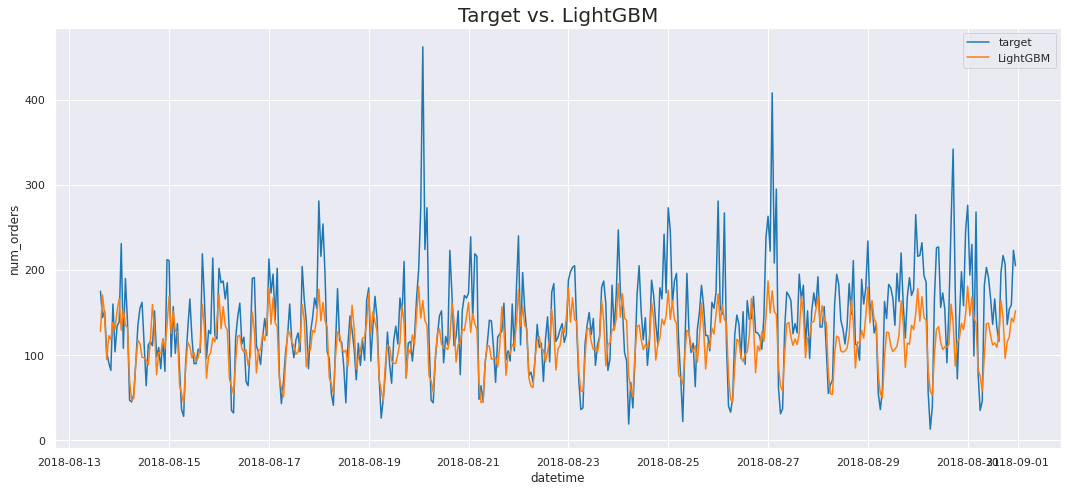

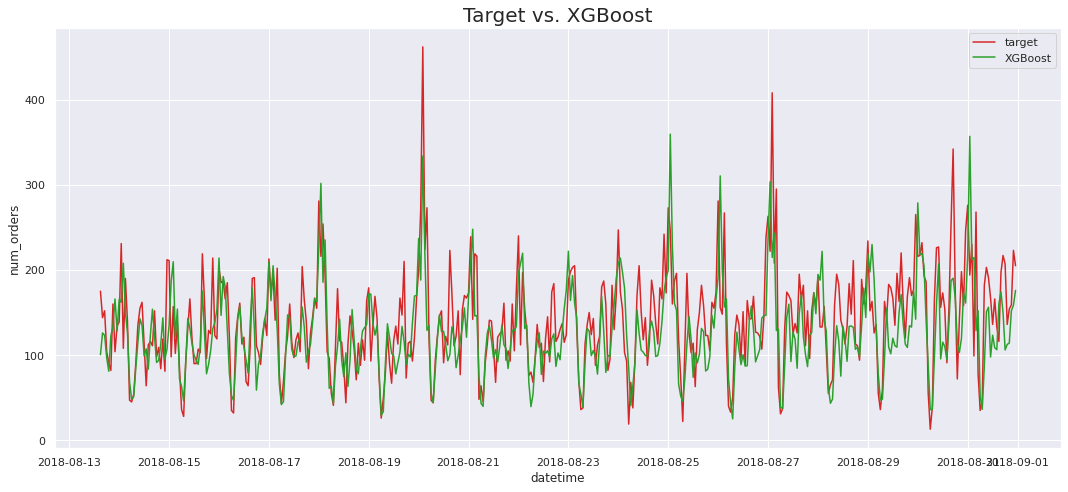

In [55]:
# Ahora comparamos las predicciones de los modelos con los target
sns.set_theme()

plt.figure(figsize=(15, 7))
sns.lineplot(data=winners_table, x=winners_table.index, y="num_orders", label="target", color='tab:blue')
sns.lineplot(data=winners_table, x=winners_table.index, y="LightGBM", label="LightGBM", color='tab:orange')
plt.title("Target vs. LightGBM", size=20)
plt.tight_layout()

plt.figure(figsize=(15, 7))
sns.lineplot(data=winners_table, x=winners_table.index, y="num_orders", label="target", color='tab:red')
sns.lineplot(data=winners_table, x=winners_table.index, y="XGBoost", label="XGBoost", color='tab:green')
plt.title("Target vs. XGBoost", size=20)
plt.tight_layout()

Menos mal que separé los gráficos para cada uno de los modelos ya que observar las 3 lineas hubiera sido imposible. Como podemos ver ambos modelos son bastante buenos para predecir el comportamiento de los viajeros del aeropuerto pero con dos "filosofías" diferentes.
  
- **LightGBM**: Si tuviese que definir la forma de actuar de éste modelo diría que es conservador. Es muy bueno describiendo el comportamiento general de los pedidos pero en donde se queda corto es en los picos y valles que se manifiestan a lo largo del gráfico jamás sobreestimando la cantidad de clientes inminentes.
- **XGBoost**: Por su parte se podría decir que éste modelo es más "apostador" ya que si bien no logra predecir con exactitud el comportamiento cíclico de los pedidos si tiene muy claro la existencias de días pico y no tiene "miedo" de arrojar un estimativo alto cuando espera un pico. Esos mismos riesgos le permiten predecir una subida en los pedidos con una sorprendente "habilidad" pero tambien sucede que se pasa o que no hay ningún pico por razones desconocidas.
  
Considerandolo todo, ambos son buenos modelos para eventualmente llevar a producción. Aunque si quedara a mí la elección iría por XGBoost ya que a pesar de que tiene un mayor RECM cumple mejor los objetivos que, creo yo, proveen más utilidad a una empresa como Sweet Lift Taxi. La normalidad es medible ,y por lo general la misma normalidad puede lidiar con ello, mientras tanto es ante la anormalidad que uno sale beneficiado cuando tiene avisos de inminencia.